In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
 
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("./egyesitett_jo.csv")
data["Date"] = pd.to_datetime(data["Date"])
data

,Date,Close,Volume,Open,High,Low,Name
0,2023-10-19,128.40,60961360,130.57,132.24,127.47,AMZN
1,2023-10-18,128.13,42699480,129.90,130.67,127.51,AMZN
2,2023-10-17,131.47,49344550,130.39,132.58,128.71,AMZN
3,2023-10-16,132.55,42832920,130.69,133.07,130.43,AMZN
4,2023-10-13,129.79,45824690,132.98,133.31,128.95,AMZN
...,...,...,...,...,...,...,...
12580,2013-10-25,11.31,113661738,11.61,11.63,11.12,TSLA
12581,2013-10-24,11.54,161740419,11.00,11.63,10.86,TSLA
12582,2013-10-23,10.97,199788950,11.26,11.45,10.68,TSLA
12583,2013-10-22,11.44,170788865,11.37,11.85,11.07,TSLA


In [3]:
amazon_close = np.array(data[data["Name"] == "AMZN"].sort_values(by = "Date")[["Close"]].values)
apple_close = np.array(data[data["Name"] == "AAPL"].sort_values(by = "Date")[["Close"]].values)
microsoft_close = np.array(data[data["Name"] == "MSFT"].sort_values(by = "Date")[["Close"]].values)
starbucks_close = np.array(data[data["Name"] == "SBUX"].sort_values(by = "Date")[["Close"]].values)
tesla_close = np.array(data[data["Name"] == "TSLA"].sort_values(by = "Date")[["Close"]].values)

In [4]:
train_size = int(len(amazon_close) * 0.95)
train, test = amazon_close[0:train_size], amazon_close[train_size:]
test_size = len(test)
test_size

126

In [5]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

In [6]:
space = {
    'p': hp.choice('p', np.arange(0, 30, dtype=int)),
    'd': hp.choice('d', np.arange(0, 30, dtype=int)),
    'q': hp.choice('q', np.arange(0, 30, dtype=int))
}

#Ezt a függvényt optimalizálja (jelen esetben minimalizálja) a hyperopt
def objective(params):
    p = params['p']
    d = params['d']
    q = params['q']
    
    
    try:
        model = ARIMA(amazon_close, order=(p, d, q))
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=test_size)
        mse = mean_squared_error(test, predictions)
        print(f"ARIMA({p},{d},{q}) MSE: {mse}")
        return {'loss': mse, 'status': STATUS_OK}
    except Exception as e:
        print(e)
        return {'loss': np.inf, 'status': STATUS_OK}

#Optimalizálás (az MSE-t akarjuk minimalizálni)
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)

print("Best: ", best)

ARIMA(20,11,10) MSE: 1.540561040285805e+20                                                                             
ARIMA(29,18,25) MSE: 7.004714631788367e+88                                                                             
ARIMA(19,17,25) MSE: 8.024795839202706e+84                                                                             
ARIMA(13,16,1) MSE: 7.234141964196957e+83                                                                              
ARIMA(16,26,0) MSE: 2.7720194350364993e+126                                                                            
ARIMA(24,12,9) MSE: 7.116016864999848e+24                                                                              
ARIMA(17,9,14) MSE: 530070094550241.6                                                                                  
ARIMA(26,9,20) MSE: 580663697890126.2                                                                                  
ARIMA(10,7,9) MSE: 163693706245.6241    

In [7]:
d, p, q = best["d"], best["p"], best["q"]
p, d, q

(0, 3, 15)

In [12]:
model = ARIMA(amazon_close, order=(p, d, q))
model_fit = model.fit()

#Dinamikus predikció, ami a teszthalmaz méretének megfelelő méretű   
dynamic_predictions = model_fit.get_prediction(start=-len(test), dynamic=True)

predicted_mean = dynamic_predictions.predicted_mean

conf_int = dynamic_predictions.conf_int()

#print(predicted_mean)

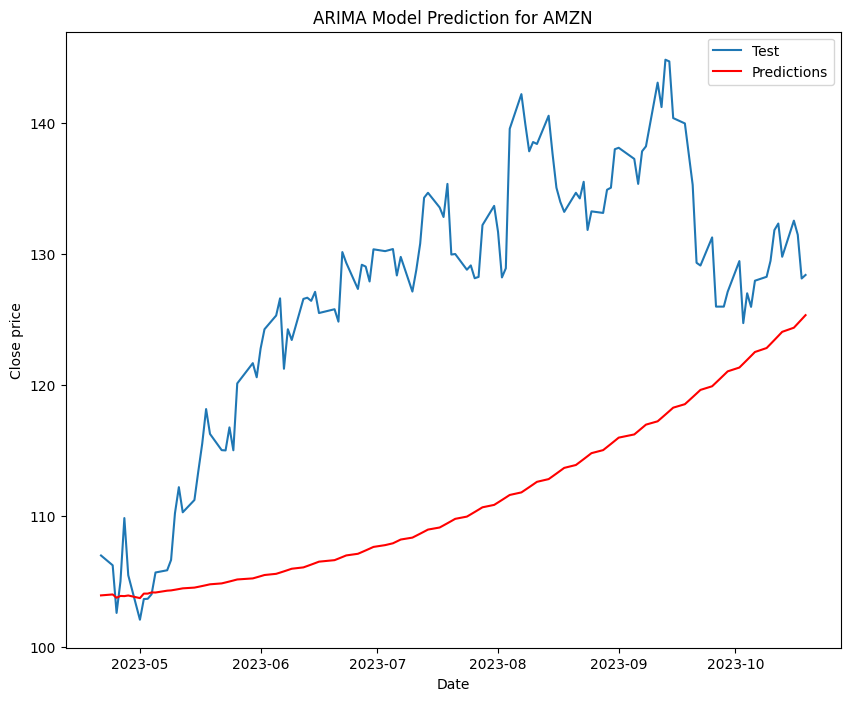

In [13]:
amazon_data = data[data["Name"] == "AMZN"].sort_values(by = "Date")

time_index = range(len(train) + len(test))
prediction_index = range(len(train), len(train) + len(predicted_mean))

plt.figure(figsize=(10, 8))


plt.plot(amazon_data["Date"].iloc[prediction_index], amazon_data["Close"].iloc[prediction_index], label='Test')


plt.plot(amazon_data["Date"].iloc[prediction_index], predicted_mean, label='Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Close price')
plt.title(f'ARIMA Model Prediction for AMZN')
plt.legend()

plt.show()